**This notebook extracts the two-photon calcium imaging data for a selected experiment. It outputs the following CSVs:**

pref_ori_ordered_subset.csv, the preferred orientation of each cell based on static grating stimuli

max_dff_subset_ordered.csv, the max dff at each NS presentation

mean_dff_subset_ordered.csv, the mean dff at each NS presentation

ns_stim_frame_presentation.csv, the frame numbers associated with each natural scene throughout the experiment

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import csv
import math
import statistics

from allensdk.core.brain_observatory_cache import BrainObservatoryCache

In [2]:
# We will create an instance of the Brain Observatory Cache as an object, "boc."
boc = BrainObservatoryCache(manifest_file='manifest.json')

**SELECTING EXPERIMENT: by visual area and cre line**

In [52]:
# Assign visual area and cre line of interest for analysis 
visual_area = 'VISp'
cre_line = 'Tlx3-Cre_PL56'

# Get experiment contianers for visual area and cre line of interest 
exp_cont = boc.get_experiment_containers(targeted_structures = [visual_area], 
                                     cre_lines = [cre_line])

# Create an experiment dataframe 
exp_cont_df = pd.DataFrame(exp_cont)

# Check if dataframe is empty 
if exp_cont_df.empty:
    print('Data frame is empty, choose another cre line & visual area combination.')

# Assign the ID column as the index and return dataframe
exp_cont_df = exp_cont_df.set_index('id')
exp_cont_df

,imaging_depth,targeted_structure,cre_line,reporter_line,donor_name,specimen_name,tags,failed
id,,,,,,,,
617381603,375,VISp,Tlx3-Cre_PL56,Ai148(TIT2L-GC6f-ICL-tTA2),336824,Tlx3-Cre_PL56;Ai148(CAM)-336824,[],False
627823571,375,VISp,Tlx3-Cre_PL56,Ai148(TIT2L-GC6f-ICL-tTA2),337458,Tlx3-Cre_PL56;Ai148-337458,[],False
648377366,375,VISp,Tlx3-Cre_PL56,Ai148(TIT2L-GC6f-ICL-tTA2),352889,Tlx3-Cre_PL56;Ai148-352889,[],False
657016265,375,VISp,Tlx3-Cre_PL56,Ai148(TIT2L-GC6f-ICL-tTA2),357093,Tlx3-Cre_PL56;Ai148-357093,[],False
637671552,375,VISp,Tlx3-Cre_PL56,Ai148(TIT2L-GC6f-ICL-tTA2),340430,Tlx3-Cre_PL56;Ai148-340430,[],False
637669268,375,VISp,Tlx3-Cre_PL56,Ai148(TIT2L-GC6f-ICL-tTA2),340427,Tlx3-Cre_PL56;Ai148-340427,[],False


In [3]:
# Assign experiment container id and stimuli 
# exp_container_id = 627823571
exp_container_id = 648377366
stim = ['natural_scenes']

# Call experiment container for our id and stimuli of interest
experiments = boc.get_ophys_experiments(experiment_container_ids = [exp_container_id],
                                   stimuli = stim)

# Print out our container 
print(experiments)

[{'id': 648644110, 'imaging_depth': 375, 'targeted_structure': 'VISp', 'cre_line': 'Tlx3-Cre_PL56', 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)', 'acquisition_age_days': 81, 'experiment_container_id': 648377366, 'session_type': 'three_session_B', 'donor_name': '352889', 'specimen_name': 'Tlx3-Cre_PL56;Ai148-352889', 'fail_eye_tracking': False}]


In [4]:
boc.get_all_stimuli() # all stimuli (checking if this experiment has natural scenes and static gratings)

['drifting_gratings',
 'locally_sparse_noise',
 'locally_sparse_noise_4deg',
 'locally_sparse_noise_8deg',
 'natural_movie_one',
 'natural_movie_three',
 'natural_movie_two',
 'natural_scenes',
 'spontaneous',
 'static_gratings']

In [5]:

stim = ['natural_scenes']

# Get experiments for our container id and stimuli of interest
experiments = boc.get_ophys_experiments(experiment_container_ids = [exp_container_id],
                                     stimuli = stim)

# Assign the experiment id 
experiment_id = experiments[0]['id']
experiment_data = boc.get_ophys_experiment_data(experiment_id)

print('Data acquired.')

2023-12-09 13:43:47,266 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/648830301


Data acquired.


In [6]:
# see all the attributes of experiment_data
dir(experiment_data)

['FILE_METADATA_MAPPING',
 'MOTION_CORRECTION_DATASETS',
 'PIPELINE_DATASET',
 'STIMULUS_TABLE_TYPES',
 'SUPPORTED_PIPELINE_VERSION',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_master_stimulus_table',
 '_stimulus_search',
 'get_cell_specimen_ids',
 'get_cell_specimen_indices',
 'get_corrected_fluorescence_traces',
 'get_demixed_traces',
 'get_dff_traces',
 'get_fluorescence_timestamps',
 'get_fluorescence_traces',
 'get_locally_sparse_noise_stimulus_template',
 'get_max_projection',
 'get_metadata',
 'get_motion_correction',
 'get_neuropil_r',
 'get_neuropil_traces',
 'get_pupil_location',
 'get_pupil_size',
 'get_roi_ids',
 'get_roi_mask',
 'get_roi_mask_ar

**OBTAIN STIMULUS EPOCH FRAMES & CALCIUM IMAING TRACES**

In [7]:
# stimuli presented during each epoch: start and end frame #s for each stimulus epoch
stimulus_epoch_df=experiment_data.get_stimulus_epoch_table()
stimulus_epoch_df

,stimulus,start,end
0,static_gratings,743,15190
1,natural_scenes,16093,30540
2,spontaneous,30690,39568
3,natural_scenes,39569,54015
4,static_gratings,54919,69365
5,natural_movie_one,70268,79297
6,natural_scenes,80200,96075
7,static_gratings,97355,113606


In [8]:
# ts = timestamp (frame), dff=∆F/F at each frame
ts, dff = experiment_data.get_dff_traces()

In [9]:
len(ts) # number of frames in experiment

113832

I'm making the assumption that there are extra frames at end of stimulus epoch that account for last few hundred frames of mice just chilling

**OBTAIN LIST OF NATURAL SCENE STIMULI IN ORDER OF PRESENTATION**

In [10]:
# start and end frames for each stimulus epoch

ns_start1=stimulus_epoch_df.loc[1]['start']
ns_end1=stimulus_epoch_df.loc[1]['end']

ns_start2=stimulus_epoch_df.loc[3]['start']
ns_end2=stimulus_epoch_df.loc[3]['end']

ns_start3=stimulus_epoch_df.loc[6]['start']
ns_end3=stimulus_epoch_df.loc[6]['end']

In [11]:
# img=experiment_data.get_stimulus(17000)[1]
# experiment_data.get_stimulus(17000)

In [12]:
# making list of images as np arrays (not super needed but still nice)

ns_img_list=[]

def get_ns(start, end):
    i=start
    while i < end:
        ns_img_list.append(experiment_data.get_stimulus(i)[1])
        i=experiment_data.get_stimulus(i)[0][2]['end']+1

get_ns(ns_start1, ns_end1)
get_ns(ns_start2, ns_end2)
get_ns(ns_start3, ns_end3)

In [13]:
# number of natural scenes shown in the experiment (there are 50 replicates for each natural scene)
len(ns_img_list)

5950

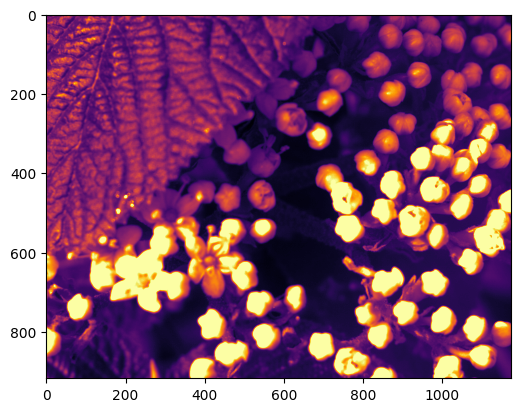

In [14]:
fig = plt.figure(figsize=(6,6))

# Use imshow to visualize any image in the list
plt.imshow(ns_img_list[100], cmap='inferno')

**GET DFF TRACES FOR EACH FRAME**

In [15]:
# remember ts = list of each frame, dff = ∆F/F at each frame

dff_stim_all=[] # dff_stim_all is a list of MAX dff over the interval of ONE natural scene presentation for EACH CELL

def get_stim(start, end):
    i=start
    while i < end:
        j=experiment_data.get_stimulus(i)[0][2]['end']
        max_dff_stim=max(cell_dff[i:j])
        dff_stim_cell.append(max_dff_stim)
        ts_in_next=experiment_data.get_stimulus(i)[0][2]['end']+1
        # start_next=experiment_data.get_stimulus(ts_in_next)[0][2]['start']
        i=ts_in_next

for k in range(len(dff)):
    
    cell_dff=dff[k]
    dff_stim_cell=[]

    get_stim(ns_start1, ns_end1)
    get_stim(ns_start2, ns_end2)
    get_stim(ns_start3, ns_end3)

    dff_stim_all.append(dff_stim_cell)

In [16]:
experiment_data.get_stimulus(17031)[0][2]['start']

17026

In [17]:
# same idea, but doing mean dff over an interval

dff_stim_avg=[]

def get_stim_avg(start, end):
    i=start
    while i < end:
        j=experiment_data.get_stimulus(i)[0][2]['end']
        avg_dff_stim=sum(cell_dff[i:j])/len(cell_dff[i:j])
        dff_stim_cell.append(avg_dff_stim)
        i=experiment_data.get_stimulus(i)[0][2]['end']+1

for k in range(len(dff)):
    
    cell_dff=dff[k]
    dff_stim_cell=[]

    get_stim_avg(ns_start1, ns_end1)
    get_stim_avg(ns_start2, ns_end2)
    get_stim_avg(ns_start3, ns_end3)

    dff_stim_avg.append(dff_stim_cell)

In [18]:
# Get the cell specimens information for this experiment
cell_specimens = boc.get_cell_specimens(experiment_container_ids=[exp_container_id])
cell_specimens_df = pd.DataFrame(cell_specimens)
# cell_specimens_df

**ORIENTATION PREFERENCE BASED ON STATIC GRATING DATA**

In [19]:
# Get experiment for our container id and stimuli of interest
stim_2 = ['static_gratings']
sg_experiment = boc.get_ophys_experiments(
                        experiment_container_ids = [exp_container_id],
                        stimuli = stim_2)

# Download the experiment data using the experiment id
experiment_id_2 = sg_experiment[0]['id']
data_sg = boc.get_ophys_experiment_data(experiment_id_2)

print('Data acquired.')

Data acquired.


In [22]:
from allensdk.brain_observatory.static_gratings import StaticGratings

# Create my StaticGratings Object 
sg = StaticGratings(data_sg)

# Return dataframe of peak conditions
sg_df = sg.peak
sg_df.head()

,ori_sg,sf_sg,phase_sg,reliability_sg,osi_sg,peak_dff_sg,ptest_sg,time_to_peak_sg,cell_specimen_id,p_run_sg,cv_os_sg,run_modulation_sg,sf_index_sg
0,5,3,2,0.035129,1.009397,8.536546,0.0,0.266,662245348,NaN,0.882459,NaN,0.202994
1,0,3,2,0.045758,0.990718,9.435566,0.000003,0.3325,662246113,NaN,0.858085,NaN,0.253633
2,1,3,0,0.233865,1.103556,26.554379,0.0,0.3325,662245580,NaN,1.0,NaN,0.388578
3,3,3,3,0.118883,1.151493,8.733431,0.0,0.3325,662246126,NaN,1.0,NaN,0.305308
4,2,2,0,0.051387,0.56425,3.952419,0.0,0.29925,662246141,NaN,0.541948,NaN,0.224569


In [23]:
cell_specimen_id=sg_df['cell_specimen_id']
num_cells=len(cell_specimen_id)

In [24]:
sg_df['ori_sg']
# values range from 0 to 5, I believe it is as follows:
# 0 = 0°, 1 = 30°, 2 = 60°, 3 = 90°, 4 = 120°, 5 = 150°

0      5
1      0
2      1
3      3
4      2
      ..
173    1
174    4
175    0
176    1
177    0
Name: ori_sg, Length: 178, dtype: object

In [25]:
# multiplying by 30 and adding to list of preferred orientations
pref_ori = []
for i in range(num_cells):
    pref_ori.append(sg_df['ori_sg'][i]*30)

In [26]:
pref_ori_dict={
    'cell_specimen_id': cell_specimen_id,
    'pref_ori': pref_ori
}
pref_ori_df=pd.DataFrame(pref_ori_dict)
pref_ori_df

,cell_specimen_id,pref_ori
0,662245348,150
1,662246113,0
2,662245580,30
3,662246126,90
4,662246141,60
...,...,...
173,662245295,30
174,662242307,120
175,662245869,0
176,662244604,30


make sure cells with preferred orientations also in natural scenes experiment and vice versa

In [27]:
cell_ids=experiment_data.get_cell_specimen_ids()

In [28]:
cell_spec_id_ori=[]
pref_ori_cell=[]

for i in range(len(pref_ori_df['cell_specimen_id'])):
    if pref_ori_df['cell_specimen_id'][i] in cell_ids:
        cell_spec_id_ori.append(pref_ori_df['cell_specimen_id'][i])
        pref_ori_cell.append(pref_ori_df['pref_ori'][i])

In [29]:
subset_pref_ori_dict={
    'cell_specimen_id': cell_spec_id_ori,
    'pref_ori': pref_ori_cell
}
subset_pref_ori_df=pd.DataFrame(subset_pref_ori_dict)
subset_pref_ori_df

,cell_specimen_id,pref_ori
0,662245348,150
1,662246113,0
2,662245580,30
3,662246126,90
4,662246141,60
...,...,...
173,662245295,30
174,662242307,120
175,662245869,0
176,662244604,30


**Extract osi_sg (orientation selectivity index) and sf_index_sg (????frequency selectivity index)**

In [30]:
osi_sg=sg_df['osi_sg']
fsi_sg=sg_df['sf_index_sg'] # there isn't any documentation stating that this is the selectivity index, but just running with it

si_dict={
    'cell_specimen_id': cell_specimen_id,
    'osi_sg': osi_sg,
    'fsi_sg': fsi_sg
}

si_df=pd.DataFrame(si_dict)

Text(0, 0.5, 'frequency selectivity index')

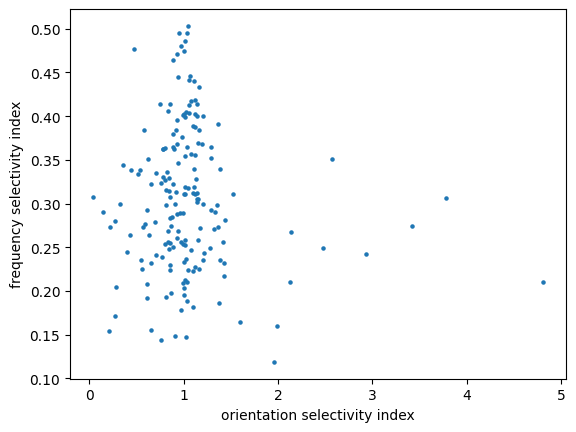

In [31]:
plt.scatter(osi_sg, fsi_sg, s=5)
plt.xlabel('orientation selectivity index')
plt.ylabel('frequency selectivity index')

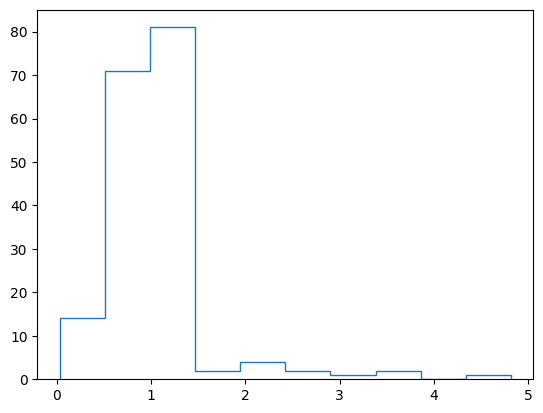

In [32]:
counts, bins = np.histogram(osi_sg)
plt.stairs(counts, bins)

**SUBSET CELLS IN CALCIUM DATA FOR NS TO COVER CELLS SHOWN SG**

In [33]:
cell_id_subset=[]
dff_subset=[]

for i in range(len(cell_ids)): #122
    if cell_ids[i] in cell_spec_id_ori:
        cell_id_subset.append(cell_ids[i])
        dff_subset.append(dff_stim_all[i])

In [34]:
# making a data frame
dff_subset_tuple=list(zip(cell_id_subset, dff_subset))
dff_subset_dict=dict(dff_subset_tuple)
dff_subset_df=pd.DataFrame(dff_subset_dict)

In [35]:
dff_subset_df_tp=dff_subset_df.transpose()
dff_subset_df_index=dff_subset_df_tp.reset_index()
dff_final_subset_df=dff_subset_df_index.rename(columns={'index':'cell_specimen_id'})

In [36]:
dff_final_subset_df.sort_values(by='cell_specimen_id')

,cell_specimen_id,0,1,2,3,4,5,6,7,8,...,5940,5941,5942,5943,5944,5945,5946,5947,5948,5949
174,662242307,0.025192,0.162529,0.061646,0.065919,0.065150,0.069372,0.079003,0.096877,-0.012464,...,0.154065,0.078022,0.063805,0.159547,0.067547,0.023005,0.122087,0.062614,0.070761,0.135733
90,662242335,0.132318,0.150763,0.104329,0.013532,0.080819,0.130854,0.158074,0.112756,0.118494,...,0.101486,0.113247,0.089326,0.024867,-0.005166,0.035662,0.070203,0.074845,0.091701,0.060737
130,662242352,0.120974,0.208191,0.159243,0.130618,0.123367,0.085317,0.037178,0.082327,0.145393,...,0.154520,0.031221,0.061705,0.065569,0.050026,0.014039,0.077223,0.047729,0.058013,0.067605
92,662242376,0.008717,0.043015,0.041003,0.041587,0.123960,0.076131,0.108234,0.047893,0.038074,...,0.025017,0.069071,0.068802,0.061078,0.060641,0.080567,0.078559,0.089860,0.070971,-0.007991
123,662242388,0.795445,0.314948,0.232224,0.137233,-0.005063,0.068218,0.168148,0.000000,0.131203,...,0.102999,0.036206,0.113211,0.077174,0.011075,0.017807,-0.007815,-0.003467,0.100906,0.146755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,662246177,0.129077,0.155151,0.132043,0.100556,0.115334,0.099820,0.479241,0.164837,0.162021,...,0.076588,0.172622,0.260520,0.108900,0.078004,0.156521,0.089289,0.039544,0.031722,0.084455
7,662246193,0.032868,0.203345,0.613084,0.199234,0.073050,0.151348,2.828383,1.719501,0.704043,...,0.430122,0.169984,0.051003,0.038099,0.082777,0.014360,0.013631,0.057813,0.028145,0.119196
6,662246207,0.144406,-0.016614,0.061721,0.025623,-0.030952,-0.076580,0.307805,0.682437,0.340270,...,0.058152,0.073364,0.085994,0.162275,0.040005,0.101165,0.064445,0.083173,0.103768,0.053007
167,662246221,0.065037,0.086324,0.122585,0.119782,0.158633,0.080357,0.122074,0.030314,0.055598,...,0.069838,0.024579,0.040168,0.097647,0.111970,0.007287,0.026694,0.053664,0.048060,0.028133


SAME PROCESS, WITH MEAN DFF

In [37]:
cell_id_subset=[]
dff_mean_subset=[]

for i in range(len(cell_ids)): #122
    if cell_ids[i] in cell_spec_id_ori:
        cell_id_subset.append(cell_ids[i])
        dff_mean_subset.append(dff_stim_avg[i])

In [38]:
# making a data frame
mean_dff_subset_tuple=list(zip(cell_id_subset, dff_mean_subset))
mean_dff_subset_dict=dict(mean_dff_subset_tuple)
mean_dff_subset_df=pd.DataFrame(mean_dff_subset_dict)

In [39]:
mean_dff_final_subset_df=mean_dff_subset_df.transpose().reset_index().rename(columns={'index':'cell_specimen_id'})

In [40]:
mean_dff_final_subset_df

,cell_specimen_id,0,1,2,3,4,5,6,7,8,...,5940,5941,5942,5943,5944,5945,5946,5947,5948,5949
0,662245348,-0.035404,0.207786,0.225408,0.069805,0.000841,-0.017721,0.014721,0.030208,0.027937,...,-0.032832,-0.016726,0.030927,-0.002543,0.038604,-0.027317,0.011286,0.015538,0.011977,-0.003832
1,662246113,-0.006547,0.045204,0.025531,0.029710,0.016181,0.010154,0.018759,0.026732,0.008784,...,0.014220,-0.015847,0.029138,0.015201,-0.028349,-0.030659,-0.010979,0.019390,-0.005478,0.010046
2,662245580,-0.004907,0.024169,0.038885,-0.033372,-0.000145,-0.012654,-0.094543,-0.141967,-0.098514,...,-0.003303,0.158511,-0.019408,-0.016128,0.075190,-0.073649,-0.134607,-0.142016,0.615947,0.151660
3,662246126,-0.022874,0.018665,0.233576,0.128290,0.159984,-0.014307,0.036217,-0.014412,-0.047919,...,0.052672,-0.019886,-0.000994,-0.036277,-0.007874,-0.042890,-0.065017,-0.066263,0.063623,2.856881
4,662246141,0.013254,0.063985,0.081322,0.139792,-0.032013,0.011201,0.057749,0.053051,-0.030012,...,0.063293,0.028886,0.024704,0.015833,-0.078965,-0.017609,0.005941,-0.020674,-0.025922,-0.017043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,662245295,0.015394,0.045088,0.075994,-0.006052,0.041299,-0.071123,-0.052950,-0.131482,-0.074590,...,0.041336,0.020317,0.040473,-0.015938,-0.030111,-0.043013,-0.028804,0.012155,-0.014354,0.058732
174,662242307,-0.063942,0.061437,0.026210,-0.021049,0.015982,-0.016203,-0.007193,-0.013416,-0.056913,...,0.048170,0.029367,0.006783,0.023091,-0.012099,-0.039829,0.003221,0.005453,-0.013844,0.034119
175,662245869,-0.059531,0.208157,0.172125,-0.013505,0.023165,-0.016912,0.238431,0.210076,0.021340,...,0.074687,-0.047007,-0.010261,-0.050833,-0.030675,-0.042709,-0.033721,0.003247,0.168526,0.075640
176,662244604,0.124391,0.080060,0.049620,0.045883,-0.051151,-0.002100,0.005262,-0.015131,-0.013326,...,0.017274,-0.014233,0.022022,0.016863,-0.031763,-0.024568,-0.047518,0.010109,-0.004995,0.018547


**List of frame numbers for each natural scene presentation (better than a list of actual images themselves)**

In [41]:
ns_frame_list=[]

def get_frames(start,end):
    i=start
    while i < end:
        ns_frame_list.append(experiment_data.get_stimulus(i)[0][2]['frame'])
        i=experiment_data.get_stimulus(i)[0][2]['end']+1

get_frames(ns_start1, ns_end1)
get_frames(ns_start2, ns_end2)
get_frames(ns_start3, ns_end3)

In [42]:
ns_frame_dict={
    'frame': ns_frame_list
}
ns_frame_df=pd.DataFrame(ns_frame_dict)

In [43]:
# NO LONGER NEEDED - making an ordered list of images based on frame list to have a key of some sort

frame_count=[]
nonrepeat_ns_img_list=[]

for i in range(len(ns_img_list)):
    if ns_frame_list[i] not in frame_count:
        frame_count.append(ns_frame_list[i])
        nonrepeat_ns_img_list.append(ns_img_list[i])

frame_img=list(zip(frame_count, nonrepeat_ns_img_list))

frame_img_ordered=['None']*len(frame_img)

for i in range(len(frame_img)):
    frame_img_ordered[int(frame_img[i][0])+1]=frame_img[i]

count, ordered_ns_img=list(zip(*frame_img_ordered))

In [43]:

# for i in range(len(count)):
#     if i < 10:
#         filename = f'./ns_img_npy/ns00{i}.npy'
#     if 10 <= i <100:
#         filename = f'./ns_img_npy/ns0{i}.npy'
#     if i >= 100:
#         filename = f'./ns_img_npy/ns{i}.npy'
#     np.save(filename, ordered_ns_img[i])

**EXPORT DATAFRAMES AS CSVs**

In [53]:
save_dir = '../data/exp_' + str(exp_container_id) + '_' + visual_area + '/'
save_dir

'../data/exp_648377366_VISp/'

In [54]:
# preferred orientation for each cell (in order by cell specimen id)
ordered_pref_ori_subset=subset_pref_ori_df.sort_values(by='cell_specimen_id').reset_index().drop(['index'], axis=1)
ordered_pref_ori_subset.to_csv(save_dir + 'pref_ori_ordered_subset.csv', sep=',', index=False)

In [55]:
# max dff for each NS presentation (in order by cell specimen id)
ordered_dff_final_subset=dff_final_subset_df.sort_values(by='cell_specimen_id').reset_index().drop(['index'], axis=1)
ordered_dff_final_subset.to_csv(save_dir + 'max_dff_subset_ordered.csv', sep=',', index=False)

In [56]:
# mean dff for each NS presentation (in order by cell specimen id)
ordered_mean_dff_subset=mean_dff_final_subset_df.sort_values(by='cell_specimen_id').reset_index().drop(['index'], axis=1)
ordered_mean_dff_subset.to_csv(save_dir + 'mean_dff_subset_ordered.csv', sep=',', index=False)

In [57]:
# frame of each natural scene presented throughout the experiment
ns_stimulus_frame_presentation=ns_frame_df.to_csv(save_dir + 'ns_stim_frame_presentation.csv', sep=',', index=False)

**SOME NICE VISUALS FOR EXAMPLES / ILLUSTRATING IDEAS**

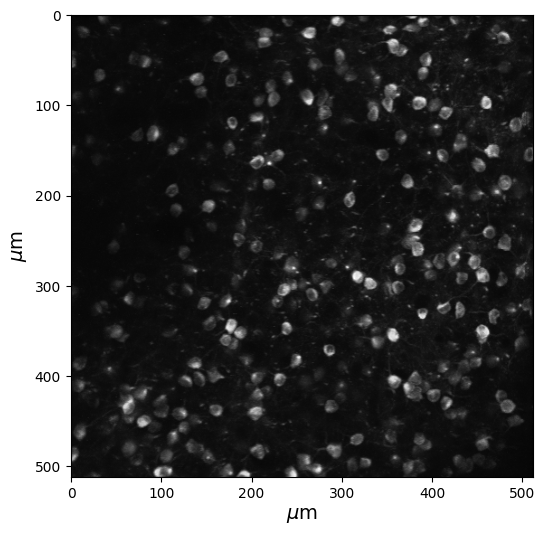

In [58]:
# Get the maximum projection (a numpy array) of our data
max_projection = experiment_data.get_max_projection()

# Create a new figure
fig = plt.figure(figsize=(6,6))

# Use imshow to visualize our numpy array
plt.imshow(max_projection, cmap='gray')

# Add labels for microns; weird syntax below is to get the micro sign
plt.ylabel(r'$\mu$m',fontsize=14)
plt.xlabel(r'$\mu$m',fontsize=14)
plt.show()

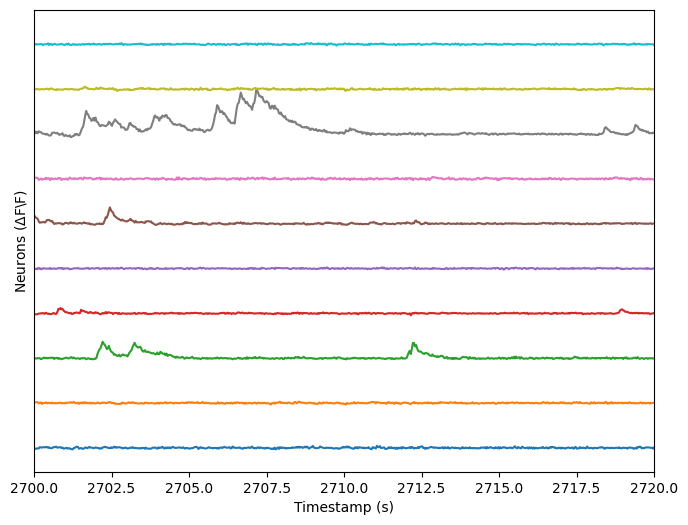

In [49]:
# Set up a figure
fig = plt.figure(figsize=(8,6))

# Loop through to add an offset on the y-axis
offset = 0
for cell in range(2,12):
    plt.plot(ts, dff[cell]+offset)
    offset+=5
    
plt.xlabel('Timestamp (s)')
plt.ylabel('Neurons ($\Delta$F\F)')
plt.yticks([])
plt.xlim([2700,2720])
plt.show()

**OBTAIN LIST OF STATIC GRATING STIMULI IN ORDER OF PRESENTATION, GET DFF TRACES FOR EACH FRAME**

In [59]:
# start and end frames for each stimulus epoch

sg_start1=stimulus_epoch_df.loc[0]['start']
sg_end1=stimulus_epoch_df.loc[0]['end']

sg_start2=stimulus_epoch_df.loc[4]['start']
sg_end2=stimulus_epoch_df.loc[4]['end']

sg_start3=stimulus_epoch_df.loc[7]['start']
sg_end3=stimulus_epoch_df.loc[7]['end']

In [60]:
experiment_data.get_stimulus(750)

((743,
  749.99,
  {'end': 750,
   'frame': nan,
   'orientation': 90.0,
   'phase': 0.25,
   'repeat': nan,
   'spatial_frequency': 0.3199999928474426,
   'start': 743,
   'stimulus': 'static_gratings'}),
 None)

In [61]:
# making dict (note, there are some random NaN in there... will deal with them)

ori_list=[]
freq_list=[]
phase_list=[]

def get_sg(start, end):
    i=start
    while i < end:
        ori_list.append(experiment_data.get_stimulus(i)[0][2]['orientation'])
        freq_list.append(experiment_data.get_stimulus(i)[0][2]['spatial_frequency'])
        phase_list.append(experiment_data.get_stimulus(i)[0][2]['phase'])
        i=experiment_data.get_stimulus(i)[0][2]['end']+1

get_sg(sg_start1, sg_end1)
get_sg(sg_start2, sg_end2)
get_sg(sg_start3, sg_end3)

sg_exp_dict={
    'orientation': ori_list,
    'frequency': freq_list,
    'phase': phase_list
}

In [62]:
# remember ts = list of each frame, dff = ∆F/F at each frame

dff_max_sg=[] # a list of MAX dff over the interval of ONE static grating presentation for EACH CELL

def get_max(start, end):
    i=start
    while i < end:
        j=experiment_data.get_stimulus(i)[0][2]['end']
        max_dff_stim=max(cell_dff[i:j])
        dff_sg_cell.append(max_dff_stim)
        i=experiment_data.get_stimulus(i)[0][2]['end']+1

for k in range(len(dff)):
    
    cell_dff=dff[k]
    dff_sg_cell=[]

    get_max(sg_start1, sg_end1)
    get_max(sg_start2, sg_end2)
    get_max(sg_start3, sg_end3)

    dff_max_sg.append(dff_sg_cell)

In [63]:
# making a data frame
dff_sg_tuple=list(zip(cell_ids, dff_max_sg))


dff_sg_dict=dict(dff_sg_tuple)
dff_sg_df=pd.DataFrame(dff_sg_dict)

dff_sg_df_tp=dff_sg_df.transpose()
dff_sg_df_index=dff_sg_df_tp.reset_index()
dff_final_sg_df=dff_sg_df_index.rename(columns={'index':'cell_specimen_id'})
dff_final_sg_df=dff_final_sg_df.sort_values(by='cell_specimen_id').reset_index().drop(columns='index')
dff_final_sg_df

,cell_specimen_id,0,1,2,3,4,5,6,7,8,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,662242307,0.067515,0.018571,0.089273,0.050187,0.214486,0.168421,0.150224,0.214382,0.048184,...,0.179961,0.041738,0.084620,0.129203,0.051322,0.046692,0.078968,0.015655,0.147938,0.144603
1,662242335,0.161424,0.187665,0.167569,0.147869,0.200779,0.101835,0.050309,0.031150,0.130972,...,0.116542,0.071630,0.102682,0.111016,0.083598,0.047506,0.067444,0.041627,0.095386,0.060432
2,662242352,0.202669,0.213155,0.293902,0.231520,0.261664,0.155633,0.144688,0.156418,0.040917,...,0.056500,0.170807,0.089617,0.004508,0.046479,0.069668,0.021208,0.121584,0.072277,0.082023
3,662242376,0.230484,0.285237,0.250527,0.157193,0.165304,0.098778,0.063769,0.075732,0.141024,...,0.090596,0.032929,0.045140,0.057160,0.083496,0.085855,0.098723,0.028594,0.083443,0.045735
4,662242388,1.011215,0.969312,0.840637,0.643479,0.236501,0.541670,0.198089,0.211591,0.193754,...,0.115497,0.116265,0.034051,0.046577,-0.051149,0.052572,0.060247,0.052869,0.111025,0.148404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,662246177,0.438044,0.318471,0.385142,0.342282,0.256187,0.194434,0.186964,0.129018,0.147015,...,0.115511,0.065008,0.151274,0.147661,0.035603,0.067122,0.002292,0.030522,0.089734,0.072440
174,662246193,0.154398,0.145607,0.159483,0.140862,0.095525,0.136835,0.051717,0.106228,0.062782,...,0.045773,0.127199,0.019180,0.065872,0.037642,0.066310,0.077816,0.050656,0.083681,-0.005846
175,662246207,0.070224,0.224037,0.067218,0.084759,0.265680,0.135635,0.017359,0.008226,0.092835,...,0.036036,0.126860,0.070082,0.083383,0.042979,0.129529,-0.005957,0.086616,0.214427,0.097210
176,662246221,0.247418,0.068638,0.883947,0.679331,0.245763,0.281457,0.213119,0.328994,0.594888,...,1.763509,0.882432,0.467255,0.215886,0.155494,0.107220,0.105740,0.065843,0.075115,0.014314


orientation/freq filtering adapted from pipeline for NS in analysis

In [64]:
# transpose df to prepare to associate with orientation and frequency data
dff_final_sg_df_t=dff_final_sg_df.T
dff_final_sg_df_t

,0,1,2,3,4,5,6,7,8,9,...,168,169,170,171,172,173,174,175,176,177
cell_specimen_id,6.622423e+08,6.622423e+08,6.622424e+08,6.622424e+08,6.622424e+08,6.622424e+08,6.622424e+08,6.622424e+08,6.622424e+08,6.622425e+08,...,6.622461e+08,6.622461e+08,6.622461e+08,6.622461e+08,6.622462e+08,6.622462e+08,6.622462e+08,6.622462e+08,6.622462e+08,6.622462e+08
0,6.751506e-02,1.614237e-01,2.026690e-01,2.304835e-01,1.011215e+00,8.871856e-02,1.830558e-01,4.670489e-01,7.811629e-02,1.357885e-01,...,8.157665e-02,7.106560e-02,2.046715e-01,2.034664e-01,2.936060e-01,4.380440e-01,1.543980e-01,7.022433e-02,2.474176e-01,1.479279e-01
1,1.857131e-02,1.876651e-01,2.131552e-01,2.852371e-01,9.693116e-01,9.103110e-02,2.155983e-01,5.030086e-01,1.438849e-01,1.059043e-01,...,2.198965e-02,7.204290e-02,1.548264e-01,1.689173e-01,2.593560e-01,3.184706e-01,1.456067e-01,2.240372e-01,6.863811e-02,1.326711e-01
2,8.927312e-02,1.675692e-01,2.939016e-01,2.505271e-01,8.406367e-01,8.449040e-03,9.617246e-02,6.013187e-01,2.677061e-01,1.025889e-01,...,7.691896e-02,1.459732e-01,1.054630e-01,1.459272e-01,1.833330e-01,3.851417e-01,1.594829e-01,6.721752e-02,8.839473e-01,3.703779e-01
3,5.018711e-02,1.478694e-01,2.315205e-01,1.571933e-01,6.434789e-01,1.338447e-01,6.539549e-02,4.316956e-01,1.860236e-01,1.649125e-01,...,7.192384e-02,1.148130e-01,2.725360e-01,1.560795e-01,2.274288e-01,3.422822e-01,1.408625e-01,8.475865e-02,6.793313e-01,1.336753e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,4.669187e-02,4.750644e-02,6.966800e-02,8.585459e-02,5.257239e-02,7.856736e-02,9.795123e-02,1.063779e-01,1.669084e-01,1.067995e-01,...,9.585979e-02,6.573024e-02,3.794656e-02,1.226200e-01,1.642325e-01,6.712164e-02,6.631017e-02,1.295287e-01,1.072204e-01,1.949705e-01
5996,7.896820e-02,6.744356e-02,2.120813e-02,9.872268e-02,6.024658e-02,3.328890e-02,9.503517e-02,1.611117e-01,2.227158e-01,5.065332e-02,...,3.161766e-02,5.492088e-02,2.559936e-01,1.367570e-01,2.608957e-02,2.292355e-03,7.781617e-02,-5.957344e-03,1.057400e-01,1.507928e-01
5997,1.565525e-02,4.162746e-02,1.215840e-01,2.859385e-02,5.286900e-02,1.801076e-01,2.054752e-02,1.756697e-01,1.732530e-01,4.574465e-02,...,1.234009e-01,1.063522e-01,1.501382e-01,9.696319e-02,8.138221e-02,3.052155e-02,5.065552e-02,8.661627e-02,6.584278e-02,7.358832e-02
5998,1.479382e-01,9.538551e-02,7.227734e-02,8.344261e-02,1.110250e-01,2.008013e-01,1.576044e-01,2.079648e-01,5.994656e-02,3.013775e-02,...,1.004868e-01,9.117734e-02,1.165524e+00,1.867827e-01,2.396035e-01,8.973396e-02,8.368120e-02,2.144274e-01,7.511494e-02,1.435535e-01


In [65]:
# produce a list of lists for the average MAX dff of each cell for each ORIENTATION (averaging across each replicate)

degrees=[0, 30, 60, 90, 120, 150]

avg_max_dff_ori_all=[] # a list of lists: 122 lists (one for each cell), avg max dff for each ori (len 6)

for j in range(len(dff_final_sg_df)): # for each cell
    
    img_max_dff_i=[[]for _ in range(len(degrees))] # empty list of 6 lists for each orientation
    
    for i in range(0, len(dff_final_sg_df_t)-1): # adding max dff scores, sorted into each list by frame number
        ori=ori_list[i]
        if math.isnan(ori):
            continue
        max_dff=dff_final_sg_df_t[j][i]
        img_max_dff_i[degrees.index(ori)].append(max_dff)

    avg_max_dff_i=[]
    
    for k in range(len(img_max_dff_i)):
        avg_max_dff=statistics.mean(img_max_dff_i[k])
        avg_max_dff_i.append(avg_max_dff)

    avg_max_dff_ori_all.append(avg_max_dff_i)

In [66]:
freq_unique=[]
for i in range(len(freq_list)):
    if freq_list[i] not in freq_unique:
        freq_unique.append(freq_list[i])
freq_unique_value=[]
for i in range(len(freq_unique)):
    if not math.isnan(freq_unique[i]):
        freq_unique_value.append(freq_unique[i])
sorted_freq=sorted(freq_unique_value)

In [67]:
# produce a list of lists for the average MAX dff of each cell for each FREQUENCY (averaging across each replicate)

avg_max_dff_freq_all=[] # a list of lists: 122 lists (one for each cell), avg max dff for each freq (len 5)

for j in range(len(dff_final_sg_df)): # for each cell
    
    img_max_dff_i=[[]for _ in range(len(sorted_freq))] # empty list of 6 lists for each orientation
    
    for i in range(0, len(dff_final_sg_df_t)-1): # adding max dff scores, sorted into each list by frame number
        freq=freq_list[i]
        if math.isnan(freq):
            continue
        max_dff=dff_final_sg_df_t[j][i]
        img_max_dff_i[sorted_freq.index(freq)].append(max_dff)

    avg_max_dff_i=[]
    
    for k in range(len(img_max_dff_i)):
        avg_max_dff=statistics.mean(img_max_dff_i[k])
        avg_max_dff_i.append(avg_max_dff)

    avg_max_dff_freq_all.append(avg_max_dff_i)

**compute significance of a peak in activity for each cell, metric is max dff / mean dff (not inclusive of max value) normalized**

In [68]:
ori_peak_sig=[]
freq_peak_sig=[]

def peak_sig(list_peak_sig, avg_max_dff):
    for j in range(len(avg_max_dff)):
        max_dff=max(avg_max_dff[j])
        list_mean_wo_max=[]
        for i in range(len(avg_max_dff[j])):
            if avg_max_dff[j][i] != max_dff:
                list_mean_wo_max.append(avg_max_dff[j][i])
        mean_wo_max=statistics.mean(list_mean_wo_max)
        peak_sig=max_dff/mean_wo_max
        list_peak_sig.append(peak_sig)

peak_sig(ori_peak_sig, avg_max_dff_ori_all)
peak_sig(freq_peak_sig, avg_max_dff_freq_all)

In [69]:
# make a dict with cell ids

peak_sig_dict={
    'cell_specimen_id': sorted(cell_ids),
    'ori_peak_sig': ori_peak_sig,
    'freq_peak_sig': freq_peak_sig
}

peak_sig_df=pd.DataFrame(peak_sig_dict)
peak_sig_df

,cell_specimen_id,ori_peak_sig,freq_peak_sig
0,662242307,1.055339,1.042054
1,662242335,1.060401,1.013586
2,662242352,1.021733,1.028944
3,662242376,1.063235,1.069960
4,662242388,1.116264,1.064545
...,...,...,...
173,662246177,1.035395,1.038830
174,662246193,1.035681,1.052423
175,662246207,1.025588,1.030776
176,662246221,1.108357,1.196321


Text(0, 0.5, 'frequency dff max/mean (exclusive of max)')

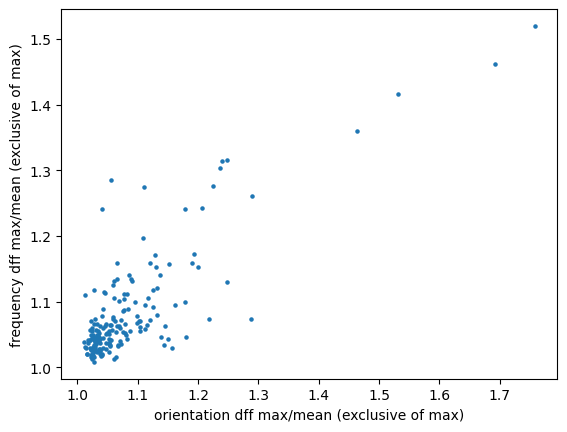

In [70]:
plt.scatter(ori_peak_sig, freq_peak_sig, marker="o", s=5)
plt.xlabel('orientation dff max/mean (exclusive of max)')
plt.ylabel('frequency dff max/mean (exclusive of max)')

In [71]:
sorted_sdk_osi_df=si_df.sort_values(by='cell_specimen_id')
sorted_sdk_osi_df['osi_sg']

174     1.29201
90     0.935088
130    0.912811
92     1.081627
123    0.705589
         ...   
5         1.954
7      0.848008
6      1.103624
167    0.995447
168    1.017305
Name: osi_sg, Length: 178, dtype: object

In [72]:
sorted_sdk_osi_df.sort_values(by='osi_sg')

,cell_specimen_id,osi_sg,fsi_sg
150,662242785,0.035199,0.307921
81,662245165,0.148191,0.290022
131,662242674,0.209598,0.153771
14,662245925,0.215782,0.273039
165,662242763,0.269892,0.171612
...,...,...,...
142,662245464,2.571531,0.35079
58,662243135,2.930681,0.241915
139,662242925,3.424414,0.274844
16,662243149,3.786107,0.306046


Text(0, 0.5, 'sdk osi')

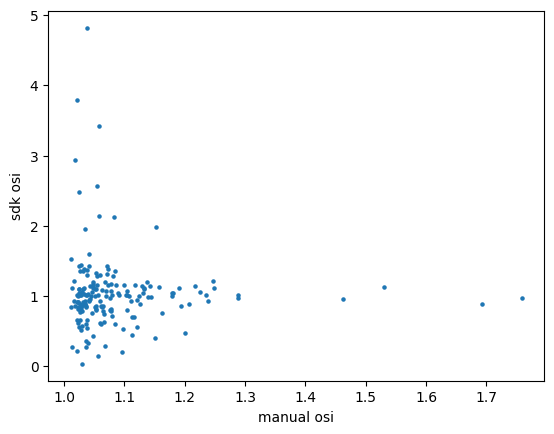

In [73]:
# x = np.random.rand(122)
# y = np.random.rand(122)
# colors = np.random.rand(122)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
# b, a = np.polyfit(ori_peak_sig, sorted_sdk_osi_df['osi_sg'].tolist(), 1)

# # Create sequence of 100 numbers from 0 to 100 
# xseq = np.linspace(1, 1.8, num=100)

plt.scatter(ori_peak_sig, sorted_sdk_osi_df['osi_sg'].tolist(), s=5)
# plt.plot(xseq, a*xseq+b)

plt.xlabel('manual osi')
plt.ylabel('sdk osi')

In [74]:
counts, bins = np.histogram(ori_peak_sig, bins=20)
# plt.stairs(counts, bins)

In [68]:
# ori_peak_sig

In [69]:
# import s

In [75]:
a = np.log(np.array(ori_peak_sig)-1)


In [76]:
two_std_log=len(a[(a-np.mean(a)) > 2*np.std(a)])
one_std_log=len(a[(a-np.mean(a)) > 1*np.std(a)])

In [77]:
b = np.array(ori_peak_sig)

In [78]:
two_std_linear=len(b[(b-np.mean(b)) > 2*np.std(b)])
two_std_linear

6

In [79]:
one_std_linear=len(b[(b-np.mean(b)) > np.std(b)])
one_std_linear

16

In [80]:
two_std_linear_df=peak_sig_df.sort_values(by='ori_peak_sig', ascending=False).head(two_std_linear)
one_std_linear_df=peak_sig_df.sort_values(by='ori_peak_sig', ascending=False).head(one_std_linear)

In [81]:
two_std_linear_df.to_csv(save_dir + 'two_std_linear.csv', index=False)
one_std_linear_df.to_csv(save_dir + 'one_std_linear.csv', index=False)

(array([ 6., 20., 39., 33., 32., 23., 13.,  8.,  1.,  3.]),
 array([-4.50533509, -4.0824636 , -3.65959211, -3.23672062, -2.81384913,
        -2.39097765, -1.96810616, -1.54523467, -1.12236318, -0.69949169,
        -0.2766202 ]),
 <BarContainer object of 10 artists>)

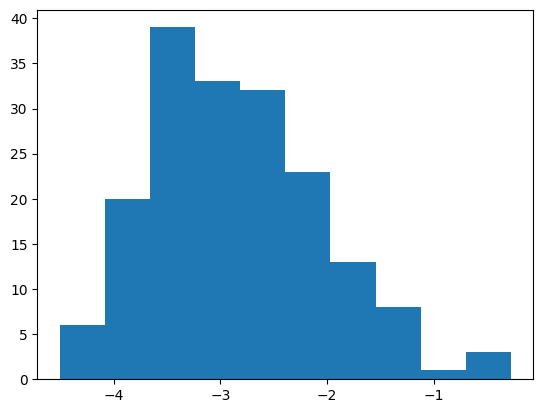

In [82]:
plt.hist(
    np.log(np.array(ori_peak_sig)-1)
)